Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64


C:\Users\nh013\AppData\Local\Temp\ipykernel_5484\2003391800.py:53: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean=df.mean()
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / n

Epoch 1/100
67/67 [==============================] - 2s 3ms/step - loss: 0.2619
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 3/100
67/67 [==============================] - 0s 3ms/step - loss: 8.4851e-04
Epoch 4/100
67/67 [==============================] - 0s 3ms/step - loss: 3.7848e-04
Epoch 5/100
67/67 [==============================] - 0s 3ms/step - loss: 2.0670e-04
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 1.3468e-04
Epoch 7/100
67/67 [==============================] - 0s 3ms/step - loss: 9.7806e-05
Epoch 8/100
67/67 [==============================] - 0s 3ms/step - loss: 8.3032e-05
Epoch 9/100
67/67 [==============================] - 0s 3ms/step - loss: 7.4539e-05
Epoch 10/100
67/67 [==============================] - 0s 3ms/step - loss: 6.4140e-05
Epoch 11/100
67/67 [==============================] - 0s 4ms/step - loss: 5.8835e-05
Epoch 12/100
67/67 [==============================] - 0s 3ms/step - loss: 4.9115e-

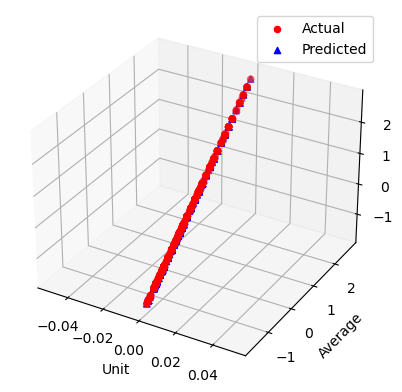

In [1]:
#NURAL NETWORK MODEL..........

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score




# USING FUNCTION TO HANDLE_OUTLIERS

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df



# DATASET

df=pd.read_csv(r'C:\Users\nh013\Desktop\tomato.csv\Tomato.csv')

# FEATURE SELECTION

df=df[['Date','Unit','Minimum','Maximum','Average','Market']]

# REPLACE 'UNKNOWN' VALUES WITH NAN VALUES IN  'UNIT' COLUMN

df['Unit'] = df['Unit'].replace('Unknown', 0)

# FILL NAN VALUES in Unit column with '0'
df['Unit'] = df['Unit'].fillna('0')

# IDENTIFYING MISSINFG VALUES

print(df.isnull().sum())


# DROP ROWS WITH MISSING VALUES

df.dropna(inplace=True)

#FILL MISSING VALUES WITH MEAN

mean=df.mean()
df.fillna(mean, inplace=True)

#FILL MISSING VALUES WITH MODE

mode=df.mode().iloc[0]
df.fillna(mode, inplace=True)

#FILL MISSING VALUES WITH FORWARD FILL

df.fillna(method='ffill', inplace=True)

#FILL MISSING VALUES WITH  BACKWARD FILL

df.fillna(method='bfill', inplace=True)

# CONVERT UNIT COLUMN TO NUMIRECAL FORMAT  (assuming all values are in kg)

df['Unit'] = pd.to_numeric(df['Unit'].str.replace('Kg', '').str.replace(',', ''))


# HANDLE OUTLIERS
df = handle_outliers(df, 'Average')

# ONE HOT ENCODE  CATEGORICAL VARIABLE'Market'
df = pd.get_dummies(df, columns=['Market'])



# REMOVE DUOLICATE ROWS

df.drop_duplicates(inplace=True)

scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

scaler = StandardScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# REPLACE 'UNKNOWN' VALUES WITH NaN VALUESin 'Unit' COLUMN
df['Unit'] = df['Unit'].replace('Unknown', 0)

# FILL NaN VALUES in Unit COLUMN with '0'
df['Unit'] = df['Unit'].fillna('0')

df['Average_rolling_mean'] = df['Average'].rolling(window=30).mean()
df['Average_rolling_std'] = df['Average'].rolling(window=30).std()

# DROP THE FIRST ROW AFTER CALCULAT ROLLING MEAN AND STD
df.dropna(inplace=True)

#SPLIT DATA INTO TRAING AND TESTING 
X = df[['Unit', 'Average', 'Average_rolling_mean', 'Average_rolling_std']]
y = df['Average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#CONVERT X AND Y SET TO FLOAT32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

#ANNs MODEL
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

#COMPILE MODEL
model.compile(loss='mean_squared_error', optimizer='adam')

#FFIT THE MODEL TO TRAING DATA
model.fit(X_train, y_train, epochs=100, batch_size=32)

#EVALUATE THE MODEL ON TESTING DATA
score = model.evaluate(X_test, y_test)
print("Test loss:", score)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: {:.2f}".format(mse))


print(df)

# Create a 3D plot of predicted vs. actual values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['Unit'], X_test['Average'], y_test, c='r', marker='o')
ax.scatter(X_test['Unit'], X_test['Average'], y_pred, c='b', marker='^')
ax.set_xlabel('Unit')
ax.set_ylabel('Average')
ax.set_zlabel('Price')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [2]:
# TRAIN MODEL USING RNNs

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense



# USING FUNCTION TO HANDLE_OUTLIERS

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df



#DATA

df=pd.read_csv(r'C:\Users\nh013\Desktop\tomato.csv\Tomato.csv')

#FEATURE SELECTION

df=df[['Date','Unit','Minimum','Maximum','Average','Market']]

# REPLACE 'UNKNOWN' VALUES WITH NAN VALUES IN  'UNIT' COLUMN
df['Unit'] = df['Unit'].replace('Unknown', 0)

# FILL NaN VALUES in Unit COLUMN with '0'
df['Unit'] = df['Unit'].fillna('0')

# IDENTIFYING MISSINFG VALUES

print(df.isnull().sum())

# DROP ROWS WITH MISSING VALUES

df.dropna(inplace=True)

#FILL MISSING VALUES WITH MEAN

mean=df.mean()
df.fillna(mean, inplace=True)

#FILL MISSING VALUES WITH MODE

mode=df.mode().iloc[0]
df.fillna(mode, inplace=True)

#FILL MISSING VALUES WITH FORWARD FILL

df.fillna(method='ffill', inplace=True)

#FILL MISSING VALUES WITH  BACKWARD FILL

df.fillna(method='bfill', inplace=True)


# CONVERT UNIT COLUMN TO NUMIRECAL FORMAT  (assuming all values are in kg)
df['Unit'] = pd.to_numeric(df['Unit'].str.replace('Kg', '').str.replace(',', ''))


# HANDLE OUTLIERS
df = handle_outliers(df, 'Average')

# ONE HOT ENCODE CATEGORICAL VARIABLE'Market'
df = pd.get_dummies(df, columns=['Market'])


# REMOVE DUPLICATE ROWS

df.drop_duplicates(inplace=True)

scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])


# NORMALIZE AND SCALING ALL NUMERICAL COLUMN
scaler = StandardScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# REPLACE 'UNKNOWN' VALUES WITH NaN VALUESin 'Unit' COLUMN
df['Unit'] = df['Unit'].replace('Unknown', 0)

# FILL NaN VALUES in Unit COLUMN with '0'
df['Unit'] = df['Unit'].fillna('0')



# Convert the datetime column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# TIME BASED FEATURE
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.weekofyear


# Set the number of time steps to use for prediction
time_steps = 30

# FUNCTION INPUT SEQUENCE
def create_sequences(values, time_steps):
    X = []
    y = []
    for i in range(time_steps, len(values)):
        X.append(values[i-time_steps:i])
        y.append(values[i])
    return np.array(X), np.array(y)

# CREATE INPUT SEQUENCE FOR TRAINING
X, y = create_sequences(df['Average'].values, time_steps)

# SPLIT DATA 
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# RNNs MODEL
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# COMPILE THE MODEL
model.compile(optimizer='adam', loss='mean_squared_error')

# TRAIN MODEL
model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=100, batch_size=32)

# EVALUATE THE MODEL ON TEST SET

loss = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print('Test loss:', loss)

# MODEL PREDICT FEATURE PRICE

future_time_steps = 7 # Predict the next 7 days
future_prices = []
last_sequence = X[-1]
for i in range(future_time_steps):
    prediction = model.predict(last_sequence.reshape((1, time_steps, 1)))
    future_prices.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

print('Predicted future prices:', future_prices)


print(df)

Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64


C:\Users\nh013\AppData\Local\Temp\ipykernel_5484\2080421066.py:50: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean=df.mean()
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / n

Epoch 1/100
67/67 [==============================] - 8s 26ms/step - loss: 0.3580
Epoch 2/100
67/67 [==============================] - 2s 27ms/step - loss: 0.2111
Epoch 3/100
67/67 [==============================] - 2s 26ms/step - loss: 0.1482
Epoch 4/100
67/67 [==============================] - 2s 26ms/step - loss: 0.1222
Epoch 5/100
67/67 [==============================] - 2s 28ms/step - loss: 0.1181
Epoch 6/100
67/67 [==============================] - 2s 30ms/step - loss: 0.1170
Epoch 7/100
67/67 [==============================] - 2s 35ms/step - loss: 0.1134
Epoch 8/100
67/67 [==============================] - 2s 32ms/step - loss: 0.1128
Epoch 9/100
67/67 [==============================] - 2s 27ms/step - loss: 0.1141
Epoch 10/100
67/67 [==============================] - 2s 27ms/step - loss: 0.1115
Epoch 11/100
67/67 [==============================] - 2s 27ms/step - loss: 0.1147
Epoch 12/100
67/67 [==============================] - 2s 30ms/step - loss: 0.1123
Epoch 13/100
67/67 [=====